## Want to build a NN to tell the difference between dog and cat

In [22]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "/Users/vineetkamat/Documents/College/Eight Semester/4701 AI Prac/kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "/Users/vineetkamat/Documents/College/Eight Semester/4701 AI Prac/kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    dogcount = 0
    catcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                
                # lot of images have useless problems
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    


  1%|          | 115/12501 [00:00<00:10, 1146.19it/s]

/Users/vineetkamat/Documents/College/Eight Semester/4701 AI Prac/kagglecatsanddogs_3367a/PetImages/Cat


  1%|          | 116/12501 [00:00<00:10, 1151.57it/s]

/Users/vineetkamat/Documents/College/Eight Semester/4701 AI Prac/kagglecatsanddogs_3367a/PetImages/Dog


100%|██████████| 12501/12501 [00:10<00:00, 1243.64it/s]


Cats:  12476
Dogs:  12470


In [23]:
#Makes matrix. nth 1 hot vector is the nth value of matrix
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [25]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [26]:
print(len(training_data))

24946


In [27]:
print(training_data[1])

[array([[ 13,  11,  13, ..., 224, 234, 234],
       [ 13,  12,  14, ..., 224, 234, 234],
       [ 13,  13,  15, ..., 224, 234, 234],
       ...,
       [ 43,  35,  12, ...,  14,  36,  44],
       [ 53,  18,  19, ...,  59,  28,  24],
       [ 31,  23,  22, ...,  35,  38,   9]], dtype=uint8)
 array([1., 0.])]


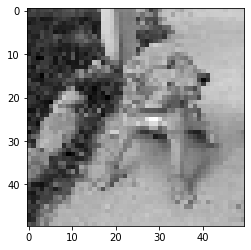

In [40]:
import matplotlib.pyplot as plt

plt.imshow(training_data[10][0], cmap="gray")
plt.show()

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear ,512)
        self.fc2 = nn.Linear(512, 2)
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    
net = Net()

torch.Size([128, 2, 2])


In [57]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss() #Mean Squared Errors

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [58]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [64]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i++BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)
        
        

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<01:18,  2.85it/s]

torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:18,  2.85it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:17,  2.88it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:17,  2.87it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:15,  2.90it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:16,  2.87it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:15,  2.88it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:15,  2.86it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:15,  2.88it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:14,  2.88it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:14,  2.88it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:13,  2.89it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:13,  2.90it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:04<01:11,  2.95it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:11,  2.94it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:11,  2.93it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:05<01:11,  2.92it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:06<01:10,  2.94it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:10,  2.91it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:06<01:10,  2.90it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:07<01:10,  2.91it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:07<01:09,  2.93it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:07<01:09,  2.92it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:08<01:08,  2.92it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:08<01:08,  2.93it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:08<01:08,  2.90it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:09<01:07,  2.92it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:09<01:06,  2.98it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:09<01:05,  3.00it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:10<01:03,  3.06it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:10<01:02,  3.11it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:10<01:01,  3.14it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:11<01:00,  3.16it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:11<01:00,  3.16it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:11<00:59,  3.18it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:12<00:59,  3.18it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:12<00:58,  3.19it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:12<00:58,  3.18it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:13<00:58,  3.18it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:13<00:58,  3.19it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:13<00:57,  3.19it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:14<00:58,  3.13it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:14<00:58,  3.12it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:14<00:57,  3.14it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:14<00:57,  3.15it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:15<00:56,  3.15it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:15<00:56,  3.16it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:15<00:55,  3.17it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:16<00:55,  3.15it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:16<00:56,  3.11it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:16<00:55,  3.14it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:17<00:54,  3.15it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:17<00:54,  3.17it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:17<00:53,  3.20it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:18<00:52,  3.21it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:18<00:52,  3.22it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:18<00:52,  3.21it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:19<00:52,  3.18it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:19<00:53,  3.09it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:19<00:54,  3.04it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:20<00:53,  3.07it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:20<00:52,  3.11it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:20<00:53,  3.04it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:21<00:53,  3.01it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:21<00:53,  2.99it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:21<00:53,  2.98it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:22<00:52,  2.99it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:22<00:52,  2.99it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:22<00:52,  2.96it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:23<00:52,  2.96it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:23<00:51,  2.98it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:23<00:52,  2.93it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:24<00:52,  2.92it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:24<00:52,  2.87it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:24<00:52,  2.88it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:25<00:51,  2.92it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:25<00:49,  3.02it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:25<00:48,  3.03it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:26<00:47,  3.06it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:26<00:47,  3.07it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:26<00:47,  3.06it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:27<00:46,  3.10it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:27<00:45,  3.12it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:27<00:44,  3.14it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:28<00:44,  3.14it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:28<00:43,  3.16it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:28<00:43,  3.18it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:28<00:43,  3.18it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:29<00:42,  3.20it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:29<00:42,  3.21it/s]

torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:29<00:41,  3.20it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:30<00:41,  3.20it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:30<00:41,  3.21it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:30<00:40,  3.22it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:31<00:40,  3.22it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:31<00:40,  3.22it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:31<00:39,  3.22it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:32<00:39,  3.19it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:32<00:39,  3.20it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:32<00:40,  3.12it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:33<00:40,  3.07it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:33<00:40,  3.01it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:33<00:40,  2.99it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:34<00:40,  2.97it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:34<00:40,  2.96it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:34<00:40,  2.95it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:35<00:39,  2.96it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:35<00:39,  2.96it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:35<00:39,  2.96it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:36<00:38,  2.97it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:36<00:38,  2.96it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:36<00:38,  2.95it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:37<00:37,  2.96it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:37<00:37,  2.98it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:37<00:36,  2.98it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:38<00:36,  2.98it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:38<00:36,  2.98it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:38<00:35,  2.99it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:39<00:35,  3.00it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:39<00:35,  3.00it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:39<00:34,  2.99it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:40<00:34,  3.00it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:40<00:33,  3.00it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:40<00:33,  3.02it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:41<00:33,  3.01it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:41<00:32,  3.00it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:41<00:32,  3.00it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:42<00:32,  3.01it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:42<00:31,  3.00it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:42<00:32,  2.95it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:43<00:31,  2.98it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:43<00:30,  3.02it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:43<00:30,  3.05it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:44<00:29,  3.06it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:44<00:28,  3.11it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:44<00:28,  3.12it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:45<00:27,  3.14it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:45<00:27,  3.17it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:45<00:27,  3.15it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:45<00:26,  3.17it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:46<00:26,  3.17it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:46<00:26,  3.19it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:46<00:25,  3.19it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:47<00:25,  3.18it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:47<00:25,  3.09it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:47<00:26,  3.02it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:48<00:25,  3.03it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:48<00:25,  2.98it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:48<00:25,  2.97it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:49<00:25,  2.97it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:49<00:24,  2.98it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:49<00:24,  2.98it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:50<00:24,  2.98it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:50<00:23,  2.97it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:50<00:23,  2.96it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:51<00:23,  2.95it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:51<00:22,  2.96it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:51<00:22,  2.98it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:52<00:22,  2.99it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:52<00:21,  3.01it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:52<00:21,  3.03it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:53<00:20,  3.02it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:53<00:20,  3.00it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:53<00:20,  3.03it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:54<00:19,  3.06it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:54<00:18,  3.11it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:54<00:18,  3.13it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:55<00:18,  3.12it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:55<00:18,  3.10it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:55<00:18,  3.05it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:56<00:18,  2.99it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:56<00:17,  2.96it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:56<00:17,  2.96it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:57<00:17,  2.99it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:57<00:16,  3.01it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:57<00:16,  3.03it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:58<00:15,  3.05it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:58<00:15,  3.10it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:58<00:14,  3.08it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:59<00:14,  3.00it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:59<00:14,  2.99it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:59<00:14,  2.97it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:00<00:14,  2.97it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:00<00:13,  2.96it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:00<00:13,  2.96it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:01<00:13,  2.95it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:01<00:12,  2.95it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:01<00:12,  2.92it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:02<00:12,  2.95it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:02<00:11,  2.96it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:02<00:11,  2.98it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:03<00:11,  2.96it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:03<00:10,  2.92it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:03<00:10,  2.91it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:04<00:10,  2.91it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:04<00:10,  2.87it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:05<00:09,  2.83it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:05<00:09,  2.85it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:05<00:09,  2.87it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:06<00:08,  2.90it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:06<00:08,  2.93it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:06<00:07,  2.93it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:07<00:07,  2.95it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:07<00:07,  2.95it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:07<00:06,  2.96it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:08<00:06,  2.97it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:08<00:06,  2.99it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:08<00:05,  2.97it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:09<00:05,  2.94it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:09<00:05,  2.90it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:09<00:04,  2.86it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:10<00:04,  2.87it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:10<00:04,  2.91it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:10<00:03,  2.94it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:11<00:03,  2.91it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:11<00:03,  2.91it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:11<00:02,  2.89it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:12<00:02,  2.92it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:12<00:02,  2.93it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:12<00:01,  2.93it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:13<00:01,  2.93it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:13<00:01,  2.94it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:13<00:00,  2.93it/s]

torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

torch.Size([128, 2, 2])
tensor(0.2203, grad_fn=<MseLossBackward>)


In [66]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy: ", round(correct/total,3))

  4%|▍         | 111/2494 [00:00<00:04, 539.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  9%|▉         | 229/2494 [00:00<00:04, 561.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 14%|█▍        | 350/2494 [00:00<00:03, 581.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 19%|█▉        | 469/2494 [00:00<00:03, 584.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 23%|██▎       | 584/2494 [00:01<00:03, 579.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 28%|██▊       | 702/2494 [00:01<00:03, 582.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 30%|███       | 760/2494 [00:01<00:03, 576.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 35%|███▌      | 875/2494 [00:01<00:02, 565.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 40%|███▉      | 993/2494 [00:01<00:02, 573.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 45%|████▍     | 1113/2494 [00:01<00:02, 583.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 49%|████▉     | 1230/2494 [00:02<00:02, 572.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 54%|█████▍    | 1347/2494 [00:02<00:02, 568.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 59%|█████▊    | 1461/2494 [00:02<00:01, 564.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 63%|██████▎   | 1575/2494 [00:02<00:01, 559.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 68%|██████▊   | 1687/2494 [00:02<00:01, 515.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 72%|███████▏  | 1792/2494 [00:03<00:01, 512.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 76%|███████▌  | 1895/2494 [00:03<00:01, 499.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 80%|████████  | 1999/2494 [00:03<00:00, 505.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 84%|████████▍ | 2104/2494 [00:03<00:00, 512.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 89%|████████▊ | 2208/2494 [00:04<00:00, 511.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 93%|█████████▎| 2312/2494 [00:04<00:00, 509.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 97%|█████████▋| 2415/2494 [00:04<00:00, 509.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:04<00:00, 544.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

In [67]:
torch.cuda.is_available()

False